In [230]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
from tqdm import tqdm

In [231]:
class Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, augmentation=False):
        self.csv_file = csv_file
        self.data_path = "../data"
        self.df = pd.read_csv(f"{self.data_path}/{self.csv_file}")
        self.transform = transform
        self.augmentation=augmentation
        self.cache = {}
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ID = self.df["ID"][idx]
        dataset = self.df["dataset"][idx]
        
        
        if f"{dataset}_{ID}" in self.cache:
            image, mask = self.cache[f"{dataset}_{ID}"]
        else:
            if dataset == "DDTI":
                image_path = self.data_path+f"/DDTI dataset/DDTI/2_preprocessed_data/stage2/p_image/{ID}.PNG"
                mask_path = self.data_path+f"/DDTI dataset/DDTI/2_preprocessed_data/stage2/p_mask/{ID}.PNG"
            elif dataset == "TG3K":
                ID = str(ID).zfill(4)
                image_path = self.data_path+f"/tg3k/thyroid-image/{ID}.jpg"
                mask_path = self.data_path+f"/tg3k/thyroid-mask/{ID}.jpg"
            elif dataset == "TN3K":
                ID = str(ID).zfill(4)
                image_path = self.data_path+f"/tn3k/trainval-image/{ID}.jpg"
                mask_path = self.data_path+f"/tn3k/trainval-mask/{ID}.jpg"
    
            image = Image.open(image_path).convert("L")
            mask = Image.open(mask_path).convert("L")
            self.cache[f"{dataset}_{ID}"] = (image, mask)
        
        if self.augmentation:
            image, mask = self.perform_aug(image, mask, 0.5)

        image_tensor = self.transform(image)
        mask_tensor = self.transform(mask)

            
        return image_tensor, mask_tensor
    def perform_aug(self, image, mask, p):

        # Random Ratation
        if random.random() > p:
            angle_range=(-15, 15)
            angle = random.uniform(*angle_range)
            image = TF.rotate(image, angle, interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)
            
        # Horizontal flip
        if random.random() > p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Scaling
        if random.random() > p:
            scale_range=(0.9, 1.1)
            scale = random.uniform(*scale_range)
        
            h, w = image.size
            new_h, new_w = int(h * scale), int(w * scale)
        
            # Resize
            image = TF.resize(image, [new_h, new_w], interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.resize(mask, [new_h, new_w], interpolation=TF.InterpolationMode.NEAREST)
        
            # 如果放大 -> 中心裁切回原尺寸
            if scale > 1.0:
                top = (new_h - h) // 2
                left = (new_w - w) // 2
                image = TF.crop(image, top, left, h, w)
                mask = TF.crop(mask, top, left, h, w)
        
            # 如果縮小 -> padding 回原尺寸
            elif scale < 1.0:
                pad_h = h - new_h
                pad_w = w - new_w
                top = pad_h // 2
                bottom = pad_h - top
                left = pad_w // 2
                right = pad_w - left
                image = TF.pad(image, [left, top, right, bottom])
                mask = TF.pad(mask, [left, top, right, bottom])

        # Translation(平移)
        if random.random() > p:
            max_translate = 30            # dx, dy 是平移距離
            dx = random.uniform(-max_translate, max_translate)
            dy = random.uniform(-max_translate, max_translate)
        
            # image: 使用 bilinear interpolation
            image = TF.affine(
                image, angle=0, translate=(dx, dy), scale=1.0, shear=[0.0, 0.0],
                interpolation=TF.InterpolationMode.BILINEAR, fill=0
            )
        
            # mask: 使用 nearest，避免 label 值被改變
            mask = TF.affine(
                mask, angle=0, translate=(dx, dy), scale=1.0, shear=[0.0, 0.0],
                interpolation=TF.InterpolationMode.NEAREST, fill=0
            )
        if random.random() > p:
            contrast_range=(0.9, 1.1)
            factor = random.uniform(*contrast_range)
            image = TF.adjust_contrast(image, factor)


        if random.random() > p:
            brightness_range=(0.9, 1.1)
            factor = random.uniform(*brightness_range)
            image = TF.adjust_brightness(image, factor)

        if random.random() > p:
            std_range=(0.0, 0.05)
            std = random.uniform(*std_range)

            # Convert to numpy float32
            img_np = np.array(image).astype(np.float32) / 255.0
        
            noise = np.random.normal(0, std, img_np.shape).astype(np.float32)
            img_np = img_np + noise
            img_np = np.clip(img_np, 0.0, 1.0)
        
            # Convert back to PIL image
            img_uint8 = (img_np * 255).astype(np.uint8)
            image = Image.fromarray(img_uint8)
        return image, mask

In [232]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [233]:
train_dataset = Thyroid_Dataset("train.csv", transform = transform, augmentation = True)

In [234]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=False)

In [235]:
for image, mask in tqdm(train_dataloader):
    pass

100%|████████████████████████████████████████████████████████████████████████████████| 747/747 [00:36<00:00, 20.27it/s]


In [ ]:
for image, mask in tqdm(train_dataloader):
    pass

 40%|████████████████████████████████▏                                               | 300/747 [00:12<00:16, 26.39it/s]

In [225]:
image.shape


torch.Size([8, 1, 256, 256])

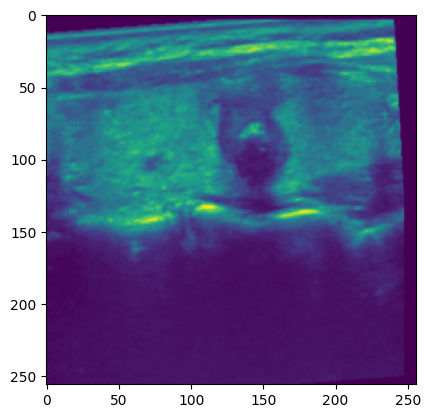

In [226]:
show_image = image[0]
to_pil = transforms.ToPILImage()
pil_image = to_pil(show_image)

plt.imshow(pil_image)

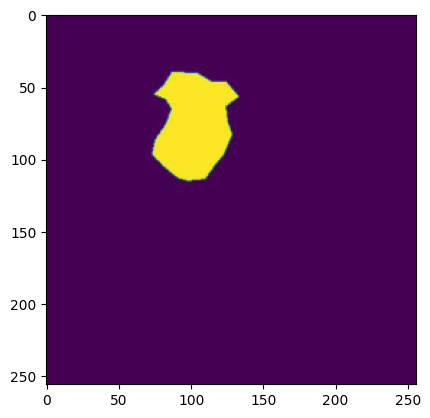

In [216]:
show_mask = mask[0]
to_pil = transforms.ToPILImage()
pil_mask = to_pil(show_mask)

plt.imshow(pil_mask)

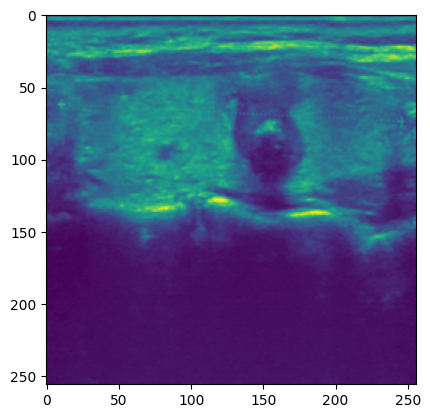

In [71]:
show_image = image[0]
to_pil = transforms.ToPILImage()
pil_image = to_pil(show_image)

plt.imshow(pil_image)

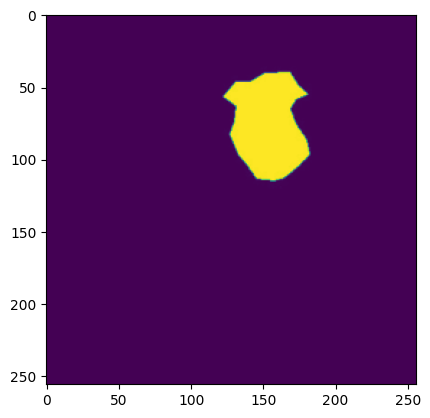

In [72]:
show_mask = mask[0]
to_pil = transforms.ToPILImage()
pil_mask = to_pil(show_mask)

plt.imshow(pil_mask)